In [3]:
%%capture
%run preprocessing.ipynb

In [4]:
# Affiche les variables et modules importés depuis le notebook preprocessing.ipynb
%whos

Variable   Type         Data/Info
---------------------------------
flipkart   DataFrame                             <...>\n[1050 rows x 4 columns]
gc         module       <module 'gc' (built-in)>
msno       module       <module 'missingno' from <...>\missingno\\__init__.py'>
os         module       <module 'os' (frozen)>
pd         module       <module 'pandas' from 'c:<...>es\\pandas\\__init__.py'>
plt        module       <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>


In [1]:
# Autres imports
from tqdm import tqdm
import numpy as np 
import pandas as pd
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display

import cv2
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.applications.efficientnet import decode_predictions as efficientnet_decode_predictions

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model

# Définit le nombre de coeurs utilisés à 10
os.environ['LOKY_MAX_CPU_COUNT'] = '10'

Le dataframe flipkart a été chargé lors du préprocessing dans les globals, réassignons le au nom flipkart pour plus de clarté.

In [6]:
image_df = globals()['flipkart']
image_df.drop(columns=['product_name', 'description'], inplace=True)
print(image_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   image   1050 non-null   object  
 1   class   1050 non-null   category
dtypes: category(1), object(1)
memory usage: 9.7+ KB
None


**INITIALISE LE MODELE AVEC TOUTES LES LAYERS SANS AUCUN POIDS + CHANGEMENT DE LA COUCHE DE SORTIE A 7 CLASSES**

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [8]:
n_classes = image_df['class'].nunique()

In [15]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    input_shape=(224, 224, 3),
    classes=7,
    classifier_activation='softmax'
)

In [9]:
model = EfficientNetB0(
    include_top=True)
model_without = EfficientNetB0(
    include_top=False)
print(len(model.layers))
print(len(model_without.layers))
n_last_layers = len(model.layers) - len(model_without.layers)
model.layers[-n_last_layers:]

241
238


[<GlobalAveragePooling2D name=avg_pool, built=True>,
 <Dropout name=top_dropout, built=True>,
 <Dense name=predictions, built=True>]

Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/10


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 329s 7s/step - accuracy: 0.1608 - loss: 4.4131 - val_accuracy: 0.0905 - val_loss: 2.0534
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 193s 7s/step - accuracy: 0.2300 - loss: 2.5947 - val_accuracy: 0.1333 - val_loss: 1.9797
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 193s 7s/step - accuracy: 0.2404 - loss: 2.3678 - val_accuracy: 0.0905 - val_loss: 2.1751
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 186s 7s/step - accuracy: 0.3372 - loss: 2.2047 - val_accuracy: 0.3952 - val_loss: 1.8974
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 174s 6s/step - accuracy: 0.3534 - loss: 2.1139 - val_accuracy: 0.0857 - val_loss: 2.2580
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 182s 6s/step - accuracy: 0.4122 - loss: 1.9838 - val_accuracy: 0.0429 - val_loss: 2.3418
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 191s 7s/step - accuracy: 0.4774 - loss: 1.6880 - val_accuracy: 0.0905 - val_loss: 2.3936
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 185s 6s/step - accuracy: 0.4918 - loss: 1.6703 - val_accuracy: 0.0429 - val_loss: 2.

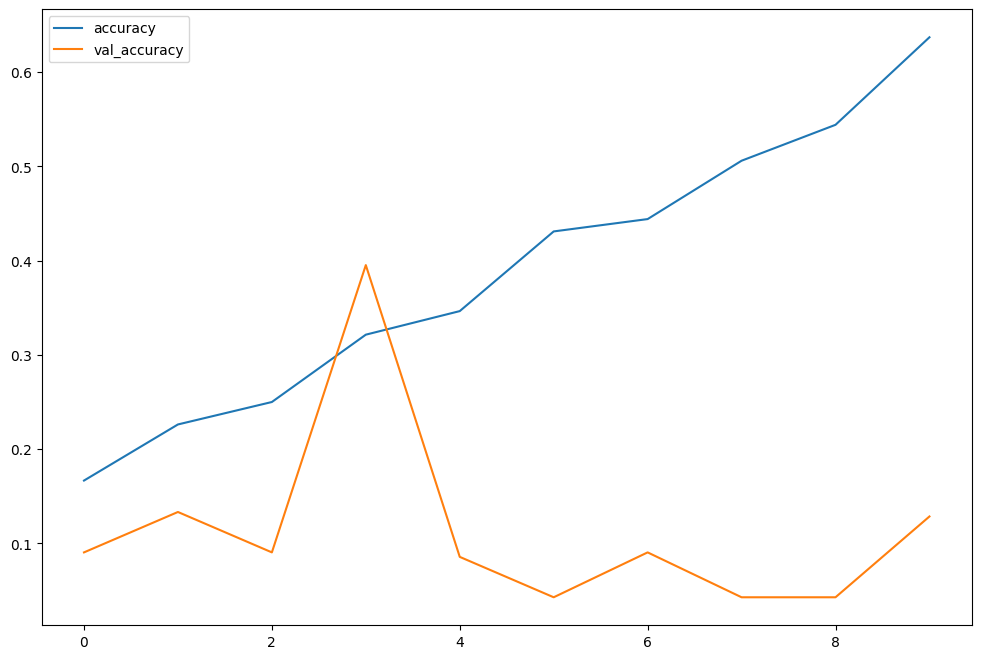

In [8]:
datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Compile le modèle

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entraîne le modèle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [21]:
# SCENARIO 2 : On utilise les poids pré-entraînés sur ImageNet et on entraîne uniquement les dernières couches denses
model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classes=7,
    classifier_activation='softmax'
)

print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Gèle les poids des couches de convolution
for layer in model.layers[:-2]:
    layer.trainable = False

# Compile le modèle
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_1199>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_1436>


Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/10


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/27 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5763 - loss: 1.1714

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6438 - loss: 1.0153 - val_accuracy: 0.8571 - val_loss: 0.5704
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9526 - loss: 0.1600 - val_accuracy: 0.7333 - val_loss: 0.7247
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9909 - loss: 0.0647 - val_accuracy: 0.8143 - val_loss: 0.5762
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9994 - loss: 0.0282 - val_accuracy: 0.7905 - val_loss: 0.6881
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 1.0000 - loss: 0.0154 - val_accuracy: 0.8381 - val_loss: 0.6125
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 1.0000 - loss: 0.0110 - val_accuracy: 0.8333 - val_loss: 0.6432
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9994 - loss: 0.0081 - val_accuracy: 0.8238 - val_loss: 0.6771
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9983 - loss: 0.0098 - val_accuracy: 0.8190 - val_loss: 0.6795
Epo

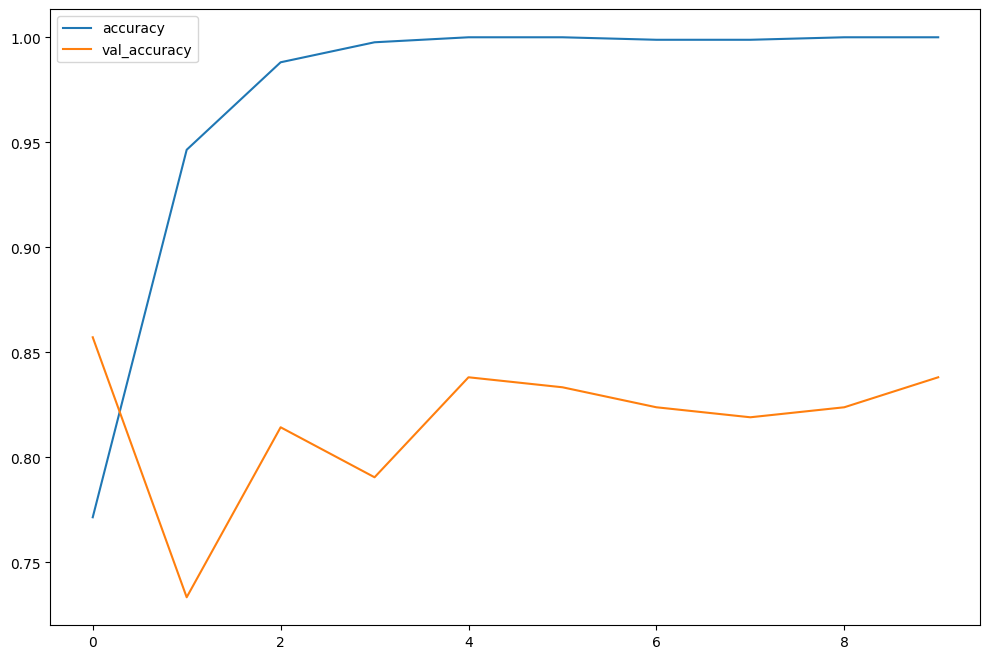

In [22]:
datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Entraîne le modèle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [23]:
# SCÉNARIO 3 : On utilise le même modèle que dans le scénario 2 et avec de la data augmentation
model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classes=7,
    classifier_activation='softmax'
)

print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Gèle les poids des couches de convolution
for layer in model.layers[:-2]:
    layer.trainable = False

# Compile le modèle
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_1440>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_1677>


Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/10


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 8/27 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5281 - loss: 1.3935

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.6790 - loss: 1.0029 - val_accuracy: 0.8333 - val_loss: 0.6449
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9139 - loss: 0.2550 - val_accuracy: 0.8381 - val_loss: 0.5750
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9594 - loss: 0.1515 - val_accuracy: 0.7857 - val_loss: 0.7405
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9781 - loss: 0.0865 - val_accuracy: 0.7857 - val_loss: 0.7594
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9802 - loss: 0.0658 - val_accuracy: 0.8000 - val_loss: 0.6526
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9767 - loss: 0.0613 - val_accuracy: 0.7905 - val_loss: 0.7251
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9823 - loss: 0.0633 - val_accuracy: 0.7905 - val_loss: 0.8224
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9934 - loss: 0.0309 - val_accuracy: 0.8000 - val_loss: 0.7692
Epo

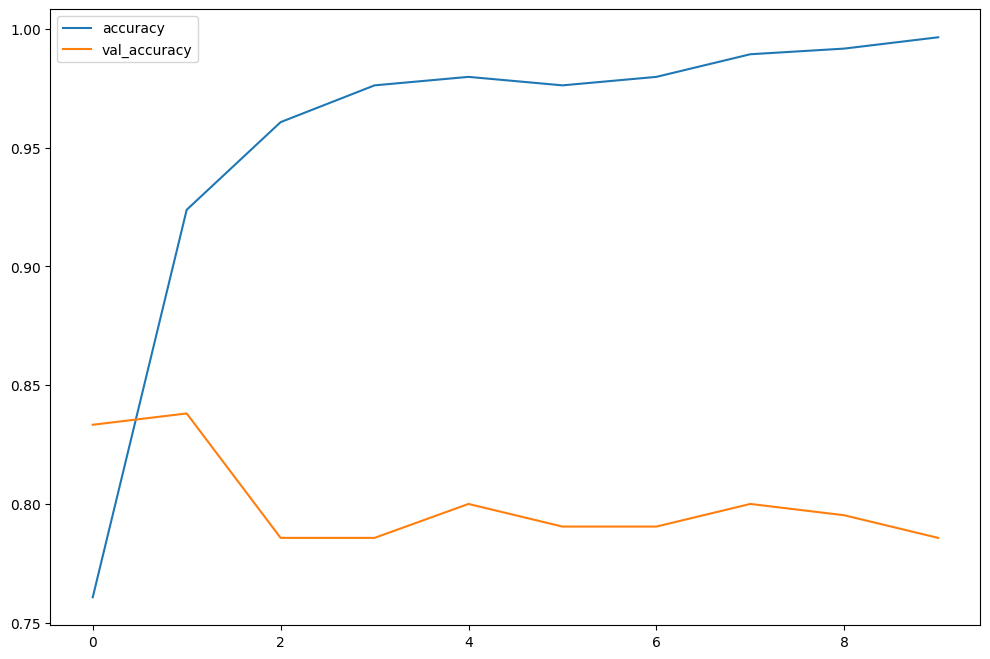

In [24]:
datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Entraîne le modèle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [25]:
# SCÉNARIO 4 : On utilise le même modèle que dans le scénario 2 et avec de la data augmentation et des paramètres d'optimisation différents pour le learning rate plus doux et 50 epochs
model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classes=7,
    classifier_activation='softmax'
)

print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Gèle les poids des couches de convolution
for layer in model.layers[:-2]:
    layer.trainable = False

# Compile le modèle
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_1681>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_1918>


Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/10


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/27 ━━━━━━━━━━━━━━━━━━━━ 4:12 10s/step - accuracy: 0.1250 - loss: 2.1143

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4346 - loss: 1.6745 - val_accuracy: 0.4905 - val_loss: 1.4678
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8016 - loss: 0.8292 - val_accuracy: 0.5762 - val_loss: 1.1781
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8349 - loss: 0.6059 - val_accuracy: 0.6762 - val_loss: 1.0155
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8567 - loss: 0.4866 - val_accuracy: 0.7524 - val_loss: 0.8556
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8636 - loss: 0.4248 - val_accuracy: 0.7571 - val_loss: 0.7715
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8979 - loss: 0.3689 - val_accuracy: 0.7714 - val_loss: 0.7352
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9117 - loss: 0.3166 - val_accuracy: 0.7905 - val_loss: 0.7238
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9253 - loss: 0.3054 - val_accuracy: 0.7619 - val_loss: 0.7495
Epo

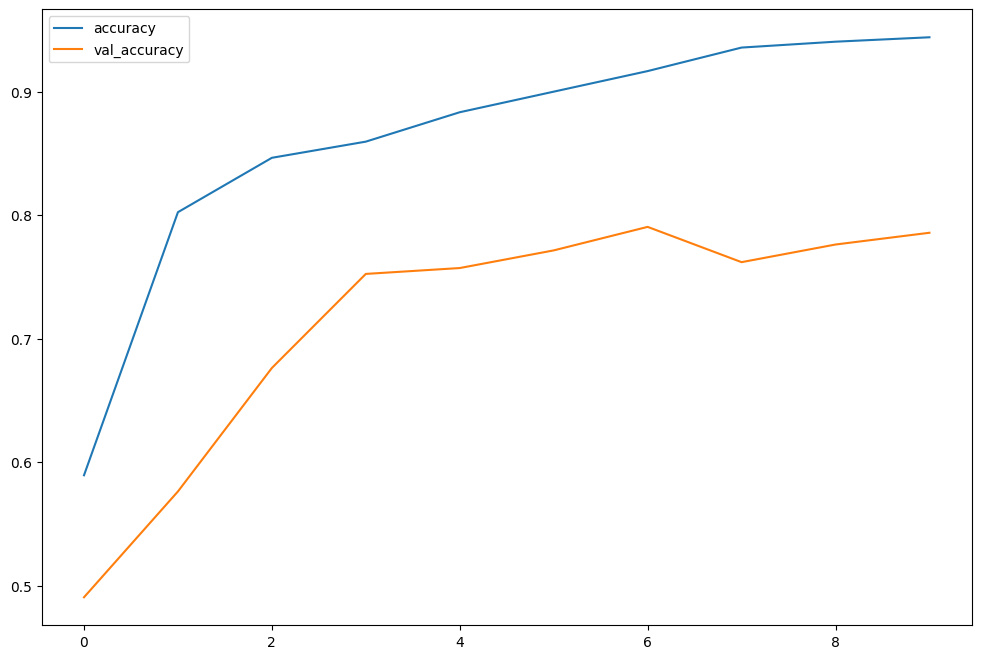

In [26]:
# Crée un datagen avec des paramètres d'optimisation différents
datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.25,
    shear_range=0.25,
)

train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Entraîne le modèle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [27]:
# SCENARIO 5 : On utilise les poids pré-entraînés sur ImageNet avec une couche dense supplémentaire et plus d'netraînement de couches
model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classes=7,
    classifier_activation='softmax'
)

print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Gèle les poids des couches de convolution
for layer in model.layers[:-6]:
    layer.trainable = False

# Compile le modèle
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_1922>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_2159>


Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/25


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4360 - loss: 1.6810 - val_accuracy: 0.5000 - val_loss: 1.4383
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8638 - loss: 0.6879 - val_accuracy: 0.7571 - val_loss: 0.9156
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9014 - loss: 0.4285 - val_accuracy: 0.8143 - val_loss: 0.7306
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9017 - loss: 0.3555 - val_accuracy: 0.8476 - val_loss: 0.6041
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9421 - loss: 0.2312 - val_accuracy: 0.8333 - val_loss: 0.6248
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9469 - loss: 0.2146 - val_accuracy: 0.8190 - val_loss: 0.6658
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9685 - loss: 0.1452 - val_accuracy: 0.8381 - val_loss: 0.6176
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9772 - loss: 0.1259 - val_accuracy: 0.8524 - val_loss: 0.5908
Epo

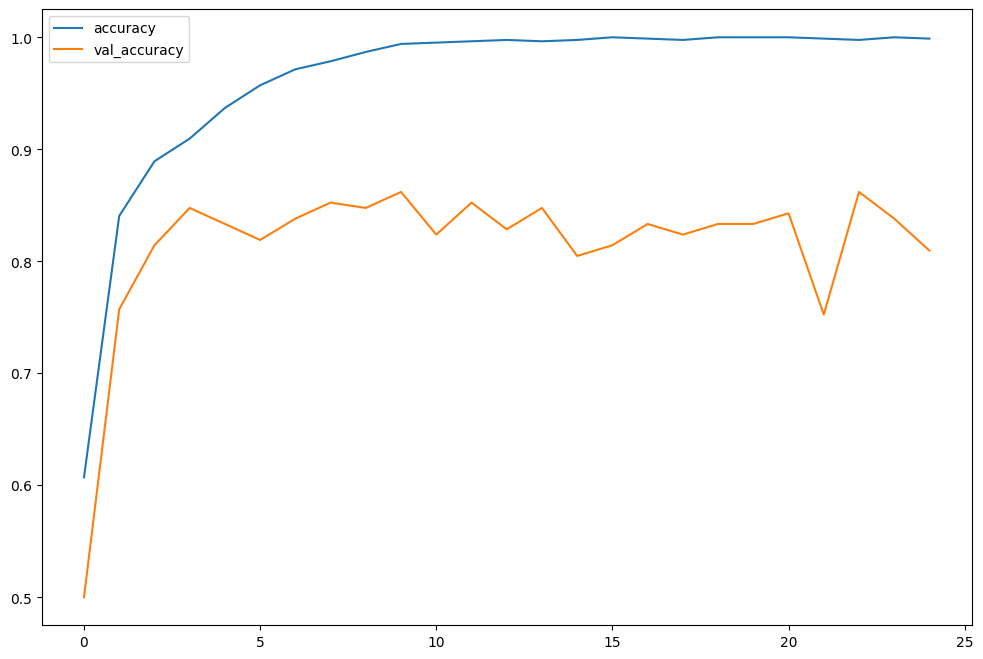

In [28]:
datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Entraîne le modèle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20
)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [16]:
model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classes=7,
    classifier_activation='softmax'
)
# Ajoute une couche de global Average Pooling
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Ajoute de dropout
x = tf.keras.layers.Dropout(0.2)(x)

# Ajoute une couche de classification à 7 classes
predictions = tf.keras.layers.Dense(7, activation='softmax')(x)

# Crée un modèle final
model = tf.keras.models.Model(inputs=model.input, outputs=predictions)

# Gèle les poids des couches de convolution
for layer in model.layers[:-6]:
    layer.trainable = False

# Compile le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/20


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5593 - loss: 1.2550 - val_accuracy: 0.7381 - val_loss: 0.7874
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9116 - loss: 0.3183 - val_accuracy: 0.8238 - val_loss: 0.6083
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9578 - loss: 0.1830 - val_accuracy: 0.8333 - val_loss: 0.5516
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9785 - loss: 0.1161 - val_accuracy: 0.7667 - val_loss: 0.6527
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9831 - loss: 0.0840 - val_accuracy: 0.8286 - val_loss: 0.5705
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9926 - loss: 0.0583 - val_accuracy: 0.8095 - val_loss: 0.5765
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9972 - loss: 0.0480 - val_accuracy: 0.8048 - val_loss: 0.6189
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9907 - loss: 0.0415 - val_accuracy: 0.8238 - val_loss: 0.5860
Epo

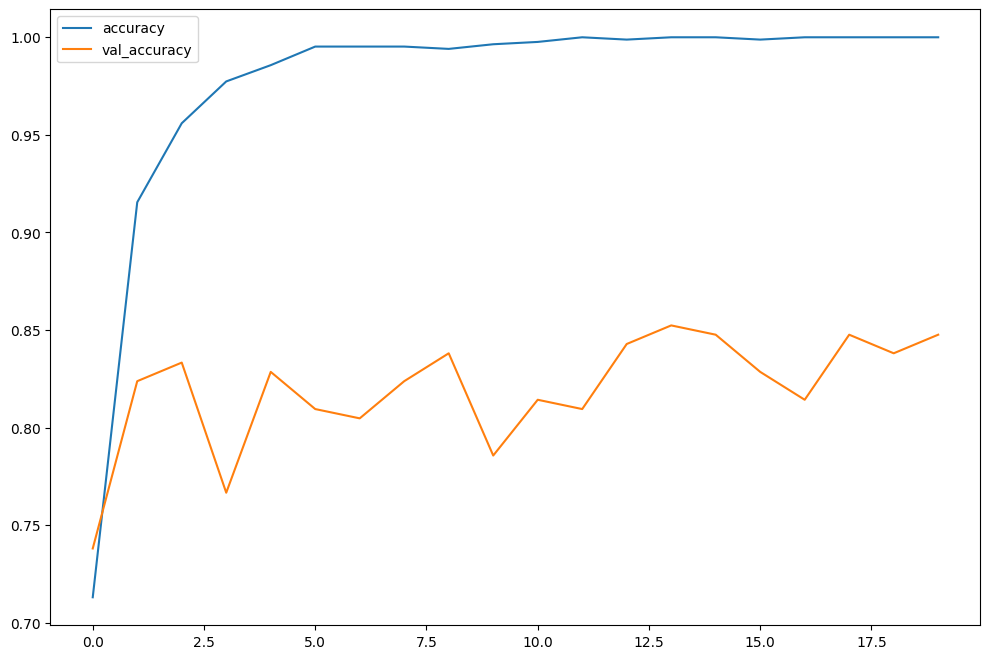

In [17]:
datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Entraîne le modèle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20
)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [26]:
# SCENARIO N : On utilise les poids pré-entraînés sur ImageNet avec une couche dense supplémentaire et plus d'netraînement de couches
model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classes=7,
    classifier_activation='softmax'
)

print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute une couche de global Average Pooling
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Ajoute de dropout
x = tf.keras.layers.Dropout(0.5)(x)

# Ajoute une couche de classification à 7 classes
predictions = tf.keras.layers.Dense(7, activation='softmax')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Gèle les poids des couches de convolution
for layer in model.layers[:-6]:
    layer.trainable = False

# Compile le modèle
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_2410>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_2647>


Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/60


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/27 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2065 - loss: 1.9912

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.2187 - loss: 1.9543 - val_accuracy: 0.2905 - val_loss: 1.8252
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4675 - loss: 1.5303 - val_accuracy: 0.4333 - val_loss: 1.6220
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5931 - loss: 1.2616 - val_accuracy: 0.4619 - val_loss: 1.4644
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6980 - loss: 1.0632 - val_accuracy: 0.5000 - val_loss: 1.3528
Epoch 5/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7024 - loss: 0.9409 - val_accuracy: 0.5571 - val_loss: 1.2697
Epoch 6/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7566 - loss: 0.8486 - val_accuracy: 0.6000 - val_loss: 1.1763
Epoch 7/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7696 - loss: 0.7692 - val_accuracy: 0.5952 - val_loss: 1.1270
Epoch 8/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7845 - loss: 0.7227 - val_accuracy: 0.6095 - val_loss: 1.1129
Epo

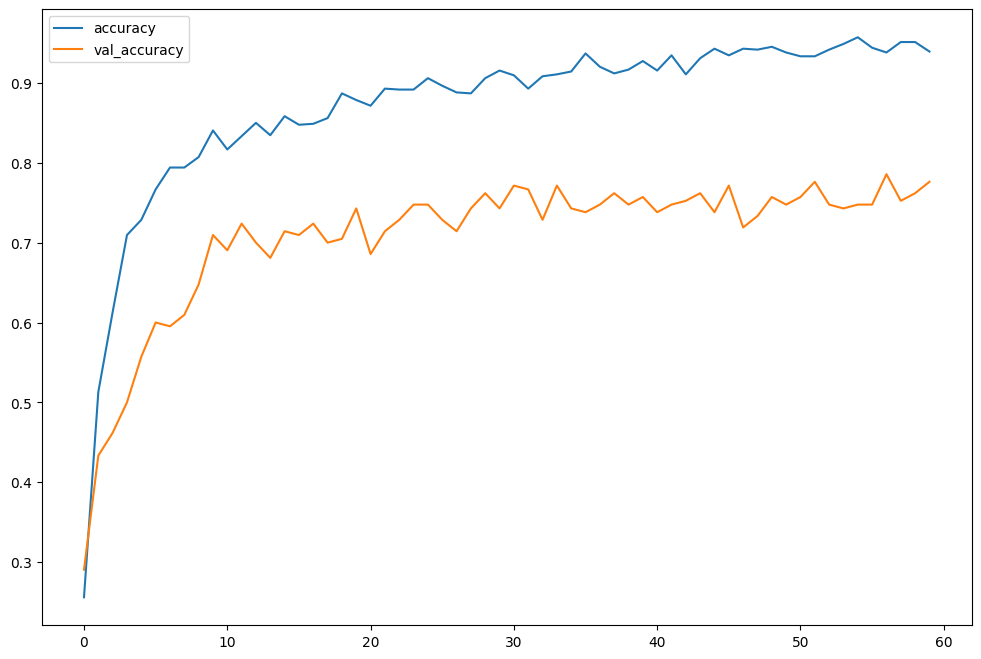

In [27]:
# Crée un datagen avec des paramètres d'optimisation différents
datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.25,
    shear_range=0.25,
)

train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Entraîne le modèle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=60
)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [30]:
def build_model(num_classes, IMG_SIZE=224):
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = Model(inputs, outputs, name="EfficientNet")
    return model

In [31]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [32]:
model = build_model(7)
unfreeze_model(model)

Epoch 1/20
 2/27 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.1719 - loss: 2.5018  

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.2018 - loss: 2.5915 - val_accuracy: 0.1714 - val_loss: 1.9886
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.2569 - loss: 2.3730 - val_accuracy: 0.2381 - val_loss: 1.9008
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.3233 - loss: 2.0867 - val_accuracy: 0.2429 - val_loss: 1.8855
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.3876 - loss: 1.9202 - val_accuracy: 0.3286 - val_loss: 1.7872
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4064 - loss: 1.7225 - val_accuracy: 0.3238 - val_loss: 1.7385
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4583 - loss: 1.5555 - val_accuracy: 0.4000 - val_loss: 1.6447
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5034 - loss: 1.5050 - val_accuracy: 0.3857 - val_loss: 1.6316
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5307 - loss: 1.3834 - val_accuracy: 0.4333 - val_loss: 1.5360
Epo

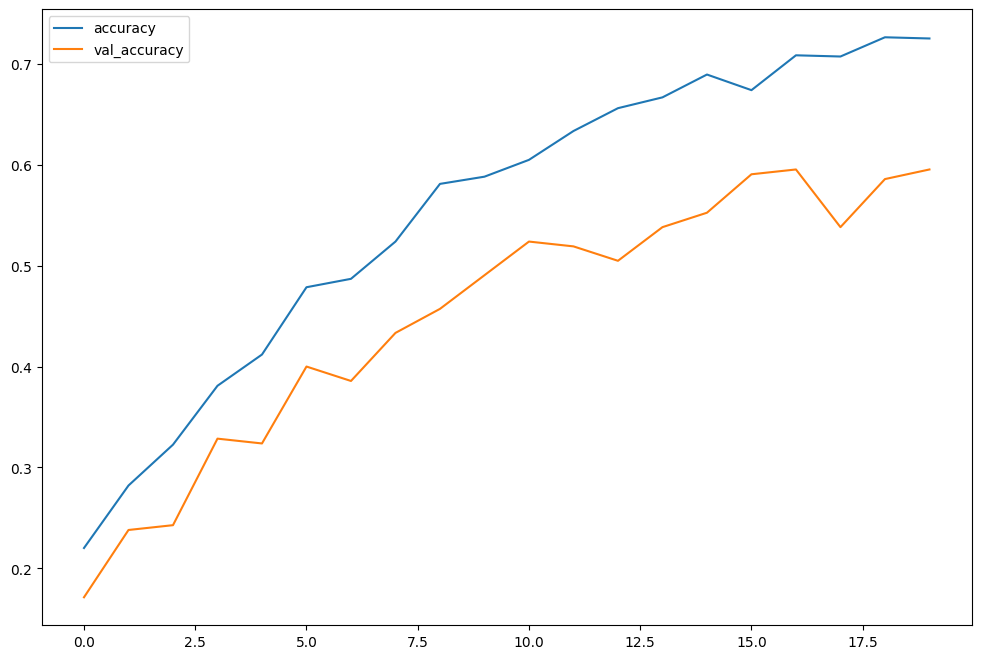

In [33]:
# Entraîne le modèle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20
)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
# Crée un datagen avec des paramètres d'optimisation différents
datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input,
    validation_split=0.2,
    rotation_range=40,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
)

train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)